In [78]:
import nltk
from langchain import hub
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, List, TypedDict

### Load PDF Document

In [ ]:
file_path = 'documents/tests/pond_or_lake.pdf'
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [14]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'GPL Ghostscript 9.10', 'creator': '', 'creationdate': '2016-03-27T16:02:40-07:00', 'moddate': '2016-03-27T16:02:40-07:00', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'source': 'documents/tests/pond_or_lake.pdf', 'total_pages': 23, 'page': 0, 'page_label': '1'}

Arch. Hydrobiol. 162 2 143–165 Stuttgart, February 2005
Pond or lake: does it make any difference?
Martin Søndergaard1 *, Erik Jeppesen1, 2 and Jens Peder Jensen1
With 7 figures and 5 tables
Abstract: T o investigate the importance of lake size, we analysed the chemical and
biological characteristics of nearly 800 Danish lakes ranging from 0.01 to 4200 ha.
Most of the lakes were shallow (median depth= 1.5 m) and eutrophic (lake water mean
total phosphorus = 0.26 mg P l–1 and mean chlorophyll-a = 60 µgl –1 ). Phosphorus and
nitrogen concentrations were unaffected by lake size, but positively related to agricul-
tural exploitation. Lakes< 1 ha showed a higher variability in phosphorus concentra-
tions,

In [47]:
# Splitting into sentences, roughly
full_content = ''
for p in pages:
    full_content += p.page_content
    
nltk.download("punkt")
nltk.download("punkt_tab")
sentences = nltk.sent_tokenize(full_content)
sentence_docs = [Document(page_content=s) for s in sentences]

[nltk_data] Downloading package punkt to /Users/kquinn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kquinn/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [48]:
sentences

['Arch.',
 'Hydrobiol.',
 '162 2 143–165 Stuttgart, February 2005\nPond or lake: does it make any difference?',
 'Martin Søndergaard1 *, Erik Jeppesen1, 2 and Jens Peder Jensen1\nWith 7 figures and 5 tables\nAbstract: T o investigate the importance of lake size, we analysed the chemical and\nbiological characteristics of nearly 800 Danish lakes ranging from 0.01 to 4200 ha.',
 'Most of the lakes were shallow (median depth= 1.5 m) and eutrophic (lake water mean\ntotal phosphorus = 0.26 mg P l–1 and mean chlorophyll-a = 60 µgl –1 ).',
 'Phosphorus and\nnitrogen concentrations were unaffected by lake size, but positively related to agricul-\ntural exploitation.',
 'Lakes< 1 ha showed a higher variability in phosphorus concentra-\ntions, but had a lower chlorophyll yield per unit of both nitrogen and phosphorus,\nwhich is indicative of less importance of nutrients in small lakes.',
 'Fish were absent in\nmost lakes smaller than 0.1 ha and mean fish biomass was markedly lower in lakes\n<1 h

### Load Model

In [ ]:
llm = ChatOllama(
    model="gemma3:1b",
    temperature=0
)

### Chat Extract

In [144]:
class State(TypedDict):
    property: str
    context: List[Document]
    questions: Annotated[list, add_messages]
    answers: Annotated[list, add_messages]
    value: float
    unit: str

starting_prompt = ChatPromptTemplate([
    ("system", "You are an assistant for scientific question-answering tasks. "
    "Use only the given pieces of context to accurately answer a series of questions. "
    "If you don't know the answer, say that you don't know. "
    "Answer each question using only a single word or numerical value.")
])

default_prompt = ChatPromptTemplate([
    ("user", "Directions: {directions}"),
    ("user", "Question: {question}"),
    ("user", "Context: {context}")
])

def yes_no_router(state: State):
    response = "Yes" if state["answers"][-1].content == "Yes\n" else "No"
    return response

def instructions(state : State):
    llm.invoke(starting_prompt.invoke({}))
    return state

def sentence_filtering(state : State):
    directions = "Answer 'Yes' or 'No' only."
    question = f"Does the context contain a value of {state['property']}?"
    context = f"Context: {state['context']}"
    message = default_prompt.invoke(
        {'directions':directions, 'question': question, 'context': context}
    )
    return {
        "questions": [question], "answers": [llm.invoke(message)]
    }

def multiple_values(state : State):
    directions = "Answer 'Yes' or 'No' only."
    question = f"Does the context contain more than one value of {state['property']}?"
    context = f"Context: {state['context']}"
    message = default_prompt.invoke(
        {'directions':directions, 'question': question, 'context': context}
    )
    return {
        "questions": [question], "answers": [llm.invoke(message)]
    }

    
memory = MemorySaver()
graph_builder = StateGraph(State)
# Nodes
graph_builder.add_node("instructions", instructions)
graph_builder.add_node("sentence_filtering", sentence_filtering)
graph_builder.add_node("multiple_values", multiple_values)
# Edges
graph_builder.add_edge(START, "instructions")
graph_builder.add_edge("instructions", "sentence_filtering")
graph_builder.add_conditional_edges(
    "sentence_filtering",
    yes_no_router,
    {"Yes": "multiple_values", "No" : END}
)
graph_builder.add_edge("multiple_values", END)
graph = graph_builder.compile(checkpointer=memory)



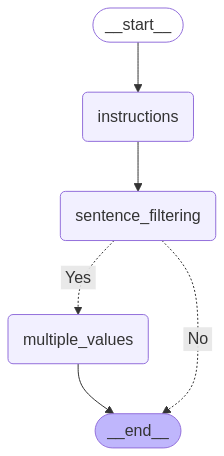

In [137]:
graph

In [145]:
config = {"configurable": {"thread_id": "1"}}
output = graph.invoke(
    {"property" : "Water Depth", "context" : sentence_docs[4]},
    config
)
output

{'property': 'Water Depth',
 'context': Document(metadata={}, page_content='Most of the lakes were shallow (median depth= 1.5 m) and eutrophic (lake water mean\ntotal phosphorus = 0.26 mg P l–1 and mean chlorophyll-a = 60 µgl –1 ).'),
 'questions': [HumanMessage(content='Does the context contain a value of Water Depth?', additional_kwargs={}, response_metadata={}, id='15cf3884-a271-470f-a751-cf231e04dd27'),
  HumanMessage(content='Does the context contain more than one value of Water Depth?', additional_kwargs={}, response_metadata={}, id='1c9ca2bc-2dc2-4923-81de-c3acd1440468')],
 'answers': [AIMessage(content='Yes\n', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-03-25T20:57:57.755317Z', 'done': True, 'done_reason': 'stop', 'total_duration': 104474916, 'load_duration': 19539833, 'prompt_eval_count': 95, 'prompt_eval_duration': 61527084, 'eval_count': 3, 'eval_duration': 22980416, 'message': Message(role='assistant', content='', images=None, tool_ca

In [140]:
sentences[4]

'Most of the lakes were shallow (median depth= 1.5 m) and eutrophic (lake water mean\ntotal phosphorus = 0.26 mg P l–1 and mean chlorophyll-a = 60 µgl –1 ).'